#### Overview:
This project aims to analyze the correlation between Bitcoin and gold and how their returns are distriubted comparatively 

I start by creating a leveraged portfolio of gold that reflect bitcoin's volatility 

I then further investigate the statics underlying bitcoin's massive outperformance of this portfolio in the 2016 to 2023 period, concluding that xxxxxxxxxx

Having done this I introduce interest rates to the leveraged portfolio and show how leverage decay will affect such a portfolio's performance, both with static and changing interest rates

Questions generated by this project for further analysis:
How does the volatility of bitcoin relate to the price of gold?
What underlying factors cause their correlation?
How could these factors be used, maybe in conjunction with the gold price itself, to create predictive models for bitcoin price?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewnorm
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns

#### Data collection and preparation

In [2]:
btc_data = yf.download('BTC-USD', start='2016-01-01', end='2023-01-01')
gold_data = yf.download('GLD', start='2016-01-01', end='2023-01-01')

btc_close = btc_data['Close']
gold_close = gold_data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Correlation Analysis

In [3]:
btc_close_aligned, gold_close_aligned = btc_close.align(gold_close, join='inner')

correlation = btc_close_aligned.corr(gold_close_aligned)
print(f"Correlation coefficient between Bitcoin and Gold: {correlation:.{3}f}")

Correlation coefficient between Bitcoin and Gold: 0.727


#### Calculate percentage changes

In [4]:
btc_daily_returns=btc_close_aligned.pct_change()
gold_daily_returns=gold_close_aligned.pct_change()

#### Calculate annualized volatility (252 trading days)

In [5]:
btc_volatility=btc_daily_returns.std() * np.sqrt(252)
gold_volatility=gold_daily_returns.std() * np.sqrt(252)

#### Calculate leverage ratios

In [6]:
btc_leverage_ratio= gold_volatility / btc_volatility
gold_leverage_ratio= btc_volatility / gold_volatility

print(f"BTC leverage ratio: {btc_leverage_ratio:.{3}f}")
print(f"Gold leverage ratio: {gold_leverage_ratio:.{3}f}")

BTC leverage ratio: 0.192
Gold leverage ratio: 5.198


#### Calculate leveraged portfolio returns for gold(no interest on leverage)

In [7]:
leveraged_gold_returns=gold_daily_returns * gold_leverage_ratio

#### Check new portfolio volatilities

In [8]:
btc_volatility=btc_daily_returns.std() * np.sqrt(252)
leveraged_gold_volatility=leveraged_gold_returns.std() * np.sqrt(252)

#### Calculate cumulative returns on leveraged gold, gold, and btc

In [9]:
cumulative_leveraged_gold=(1+leveraged_gold_returns).cumprod()-1
cumulative_gold=(1+gold_daily_returns).cumprod()-1
cumulative_btc=(1+btc_daily_returns).cumprod()-1

#### Plot original and leveraged gold portfolio against bitcoin

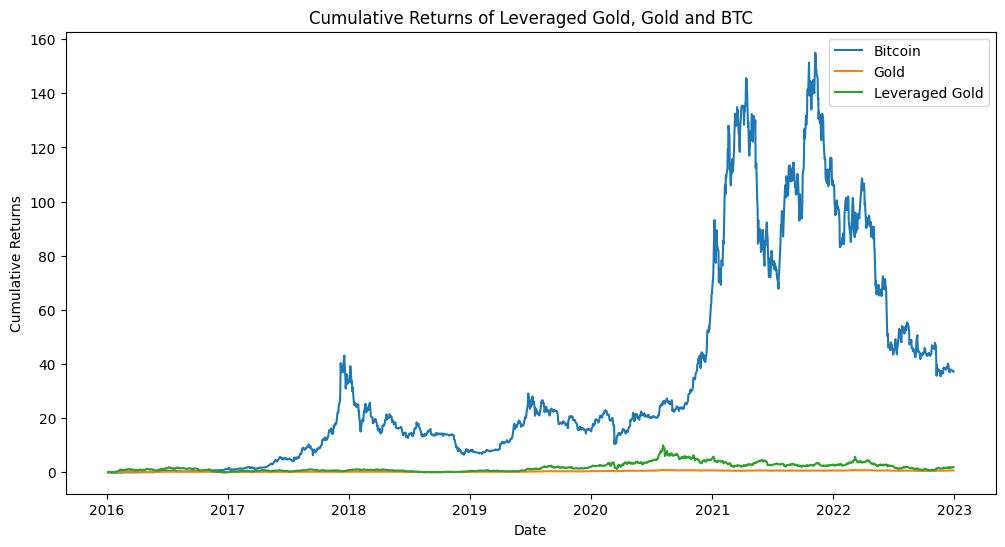

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_btc, label='Bitcoin')
plt.plot(cumulative_gold, label='Gold')
plt.plot(cumulative_leveraged_gold, label='Leveraged Gold')
plt.title('Cumulative Returns of Leveraged Gold, Gold and BTC')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

BTC appears to move in much greater magnitude (and with better overall return) than leveraged Gold over the period

#### Distribution stats

Bitcoin Statistics:
 count       1761.000000
mean           0.003144
std            0.046119
min           -0.371695
25%           -0.015600
50%            0.001964
75%            0.022303
max            0.252472
skew          -0.033515
kurtosis       6.095977
Name: Close, dtype: float64

Gold Statistics:
 count       1761.000000
mean           0.000323
std            0.008873
min           -0.053694
25%           -0.004457
50%            0.000557
75%            0.004940
max            0.049038
skew          -0.116665
kurtosis       3.583935
Name: Close, dtype: float64

Leveraged Gold Statistics:
 count       1761.000000
mean           0.001681
std            0.046119
min           -0.279081
25%           -0.023163
50%            0.002893
75%            0.025678
max            0.254881
skew          -0.116665
kurtosis       3.583935
Name: Close, dtype: float64


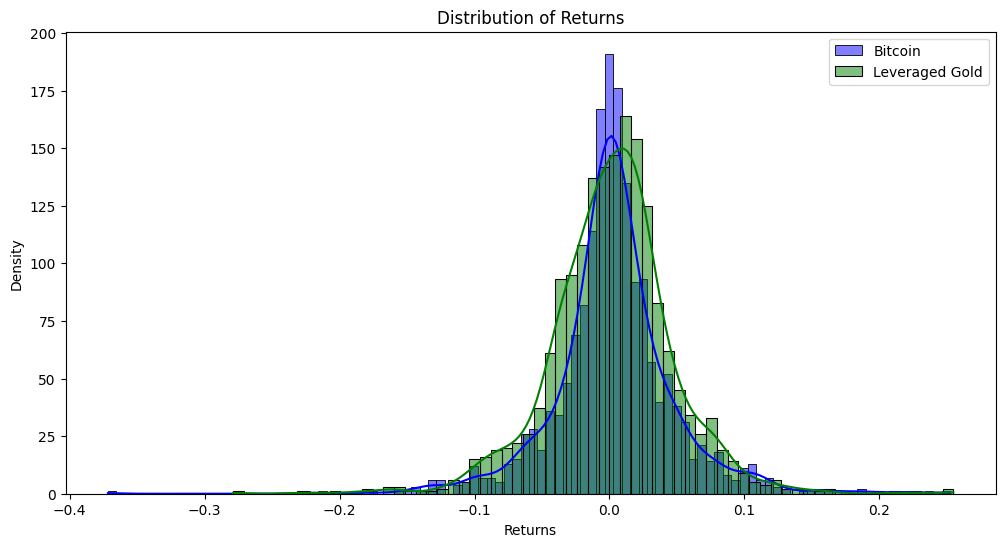

In [11]:
btc_stats = btc_daily_returns.describe()
gold_stats = gold_daily_returns.describe()
leveraged_gold_stats = leveraged_gold_returns.describe()

btc_stats['skew'] = btc_daily_returns.skew()
btc_stats['kurtosis'] = btc_daily_returns.kurtosis()
gold_stats['skew'] = gold_daily_returns.skew()
gold_stats['kurtosis'] = gold_daily_returns.kurtosis()
leveraged_gold_stats['skew'] = leveraged_gold_returns.skew()
leveraged_gold_stats['kurtosis'] = leveraged_gold_returns.kurtosis()

print("Bitcoin Statistics:\n", btc_stats)
print("\nGold Statistics:\n", gold_stats)
print("\nLeveraged Gold Statistics:\n", leveraged_gold_stats)

plt.figure(figsize=(12, 6))
sns.histplot(btc_daily_returns, color="blue", kde=True, label='Bitcoin')
sns.histplot(leveraged_gold_returns, color="green", kde=True, label='Leveraged Gold')
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

### Conclusions:

There are three ways I want to explore how these distributions are generating the interesting price action observed earlier

The first is btc has higher returns over the period: 0.31% daily as opposed to 0.17%
The second is that btc's return distributon has a more positive skew on its returns: -0.03 as opposed to -0.12
The third is that btc's return distribution has a much higher kurtosis: 6.1 as opposed to 3.6

In order to better understand the effects of these differing statistics I sample from a distribution that takes on the stats of the leveraged gold portfolio, to generate several sets of return time series. Each set will change a different statistic to that of bitcoin of: return, skew, kurtosis.

#### Store stats

In [12]:
lg_mean = leveraged_gold_returns.mean()
lg_std = leveraged_gold_returns.std()
lg_skew = leveraged_gold_returns.skew()
lg_kurt = leveraged_gold_returns.kurtosis()
btc_mean = btc_daily_returns.mean()
btc_std = btc_daily_returns.std()
btc_skew = btc_daily_returns.skew()
btc_kurt = btc_daily_returns.kurtosis()

#### Define functions for:
cumulative return calculation
data generation


In [13]:
def calc_cumulative_returns(data):
    return np.cumprod(1 + data) - 1

def generate_data(mean, std, skewness, size):
    alpha = np.fabs(skewness) if skewness >= 0 else -np.fabs(skewness)
    data = skewnorm.rvs(alpha, size=size)
    return data * std / np.std(data) + mean

n = len(btc_daily_returns)

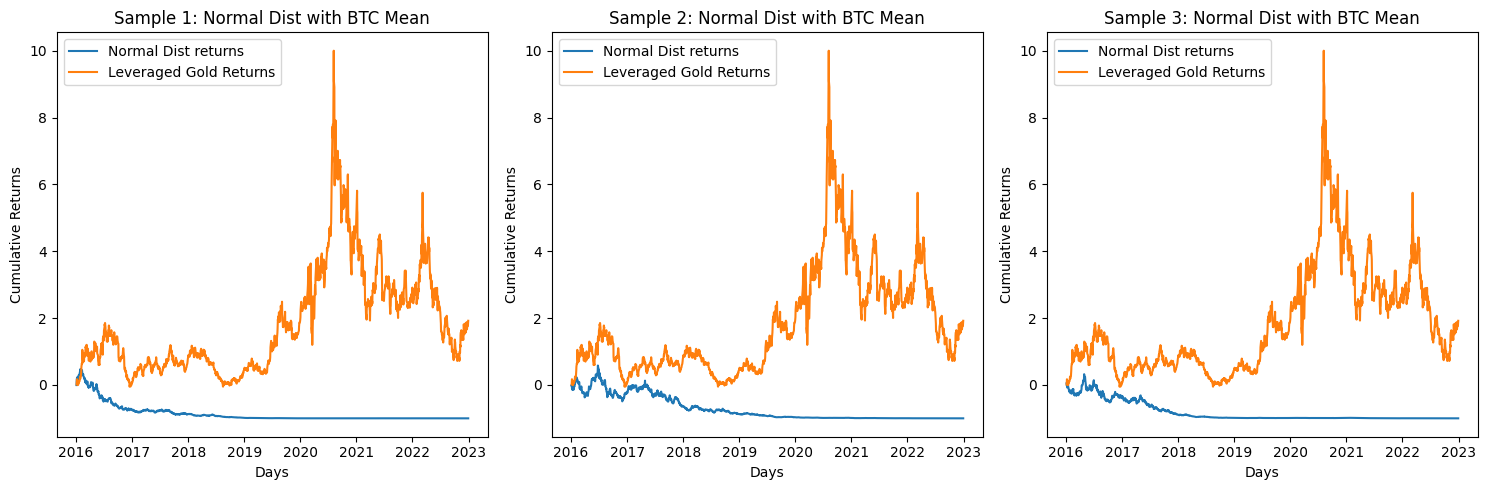

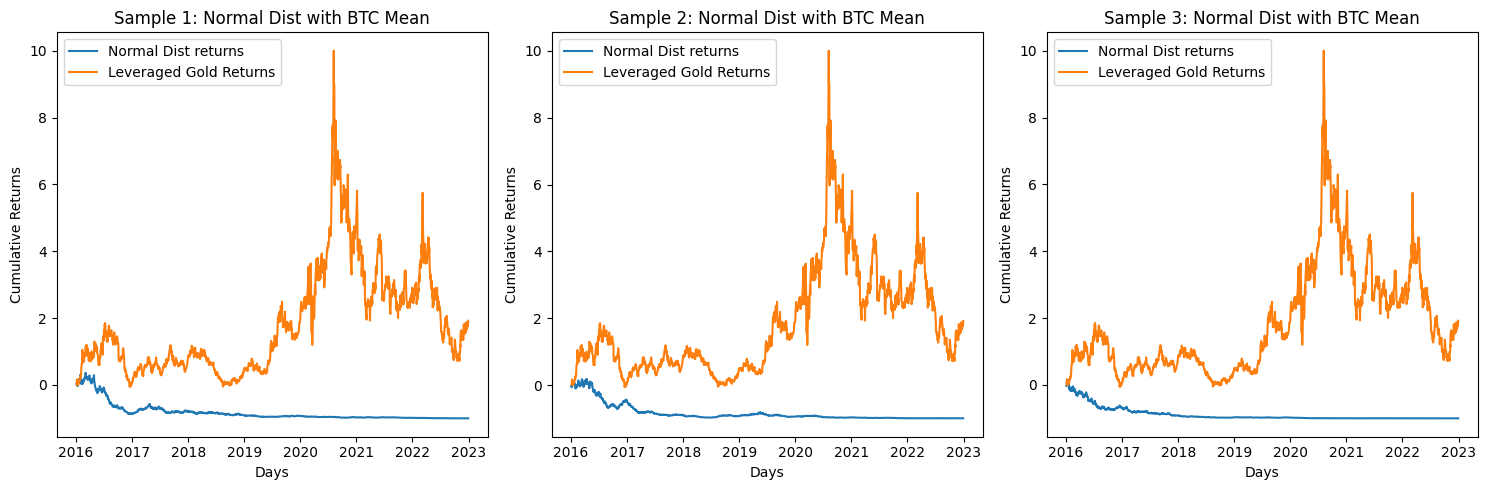

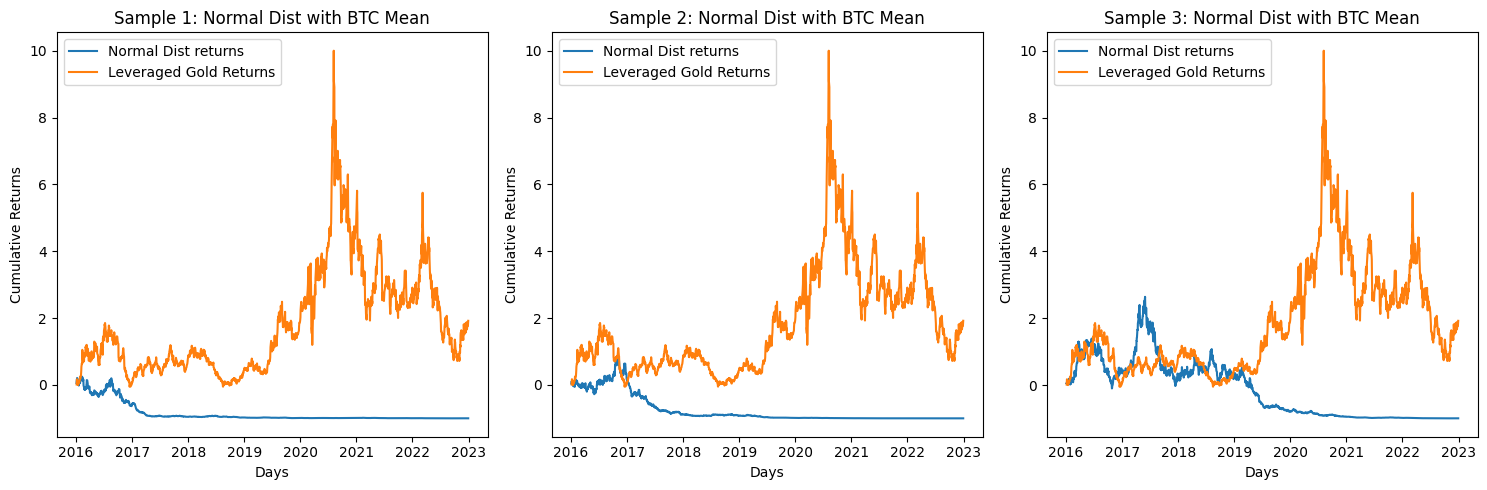

In [17]:
for i in range(1,4):
    plt.figure(figsize=(15, 5))
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        normal_data = pd.Series(generate_data(lg_mean, lg_std, lg_skew, n),index=leveraged_gold_returns.index)
        sns.lineplot(data=calc_cumulative_returns(normal_data), label='Normal Dist returns')
        sns.lineplot(data=calc_cumulative_returns(leveraged_gold_returns), label='Leveraged Gold Returns')
        plt.title(f'Sample {i}: Normal Dist with BTC Mean')
        plt.xlabel('Days')
        plt.ylabel('Cumulative Returns')
    plt.tight_layout()
    plt.show()

this shows that 

BTC skew